In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *
from Helper_functions import *

X, y, feature_names, categorical_features, continuous_features, actionable_features= get_and_preprocess_cc()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_pos = X[y == 1]
X_neg = X[y == 0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [2]:
from Model import NeuralNetwork

model0 = NeuralNetwork(X.shape[1], 200, 2)
model1= NeuralNetwork(X.shape[1], 200, 2)
model2= NeuralNetwork(X.shape[1], 200, 2)
model3= NeuralNetwork(X.shape[1], 200, 2)
model4= NeuralNetwork(X.shape[1], 200, 2)
model5= NeuralNetwork(X.shape[1], 200, 2)
model6= NeuralNetwork(X.shape[1], 200, 2)

In [3]:
models = [model0,model1, model2, model3, model4, model5, model6]
lambdas = [0,0.05,0.1,0.15,0.2,0.25,0.3]

model_path = f"models/communities_model_0.pth"
model0.load_state_dict(torch.load(model_path))
model0.eval()

# Load saved weights
for lambda_model, lamda in zip(models[1:], lambdas[1:]):
    model_path = f"models/communities_model_lambda_{lamda:.2f}.pth"
    lambda_model.load_state_dict(torch.load(model_path))
    lambda_model.eval()

## Setting up Dice

In [4]:
import dice_ml

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name='target'
)

class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, x):
        self.model.eval()
        with torch.no_grad():
            x = x.values
            x = x.astype(np.float64)
            x_tensor = torch.FloatTensor(x)
            logits = self.model(x_tensor)
            probabilities = torch.softmax(logits, dim=1)
            return probabilities.numpy()

In [5]:
cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for model in models:

    X_false_negatives, X_true_negatives, _, _ = split_by_classification(model, X_neg)

    dice_model = dice_ml.Model(
        model=PyTorchModelWrapper(model),
        backend="sklearn",
        model_type='classifier'
    )

    exp = dice_ml.Dice(
        dice_data,
        dice_model,
        method="genetic"
    )

    query_df = pd.DataFrame(X_true_negatives.numpy(), columns=feature_names)

    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=3,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    all_l1_distances = []
    all_l2_distances = []
    for i in range(len(X_true_negatives)):
        original = X_true_negatives[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df

        if cf_df is None or cf_df.empty:
            continue

        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float()
        l1_distances = torch.norm(original - cf_tensor, p=1, dim=1)
        l2_distances = torch.norm(original - cf_tensor, p=2, dim=1)
        all_l1_distances.extend(l1_distances.tolist())
        all_l2_distances.extend(l2_distances.tolist())


    # Compute mean L1 distance
    cost_of_recourses_l1.append(all_l1_distances)
    cost_of_recourses_l2.append(all_l2_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(all_l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(all_l2_distances):.2f}")

100%|██████████| 809/809 [07:18<00:00,  1.84it/s]


Mean L1 distance for negatively classified data using DiCE: 235070.98
Mean L2 distance for negatively classified data using DiCE: 104277.61


100%|██████████| 834/834 [08:10<00:00,  1.70it/s]


Mean L1 distance for negatively classified data using DiCE: 242599.94
Mean L2 distance for negatively classified data using DiCE: 108270.41


100%|██████████| 852/852 [08:26<00:00,  1.68it/s]


Mean L1 distance for negatively classified data using DiCE: 245003.19
Mean L2 distance for negatively classified data using DiCE: 109321.76


100%|██████████| 876/876 [08:54<00:00,  1.64it/s]


Mean L1 distance for negatively classified data using DiCE: 247936.50
Mean L2 distance for negatively classified data using DiCE: 109649.19


100%|██████████| 897/897 [08:58<00:00,  1.67it/s]


Mean L1 distance for negatively classified data using DiCE: 250490.75
Mean L2 distance for negatively classified data using DiCE: 110146.32


100%|██████████| 921/921 [09:05<00:00,  1.69it/s]


Mean L1 distance for negatively classified data using DiCE: 243805.35
Mean L2 distance for negatively classified data using DiCE: 106919.98


100%|██████████| 938/938 [09:21<00:00,  1.67it/s]


Mean L1 distance for negatively classified data using DiCE: 240204.35
Mean L2 distance for negatively classified data using DiCE: 104593.39


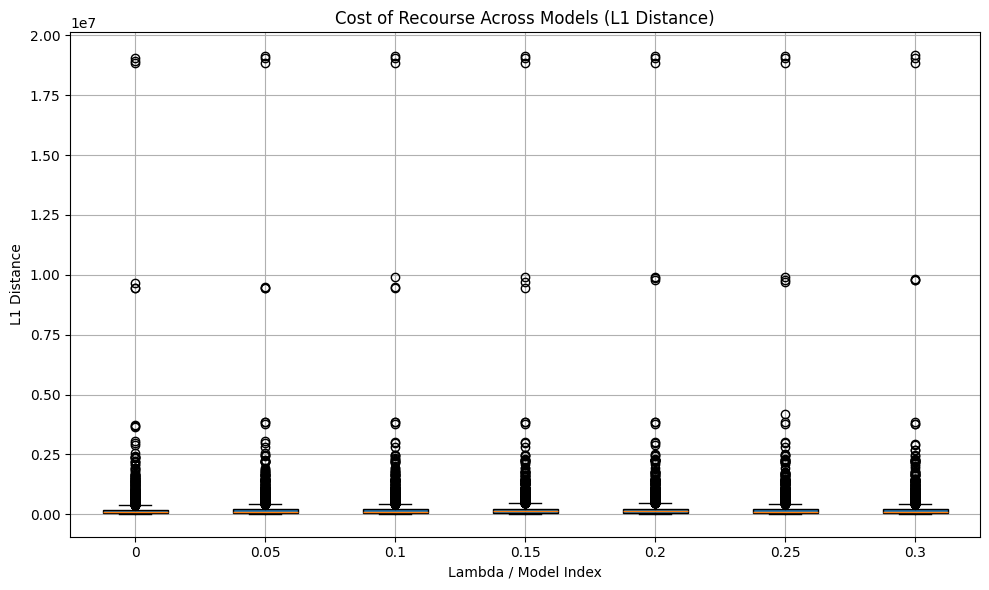

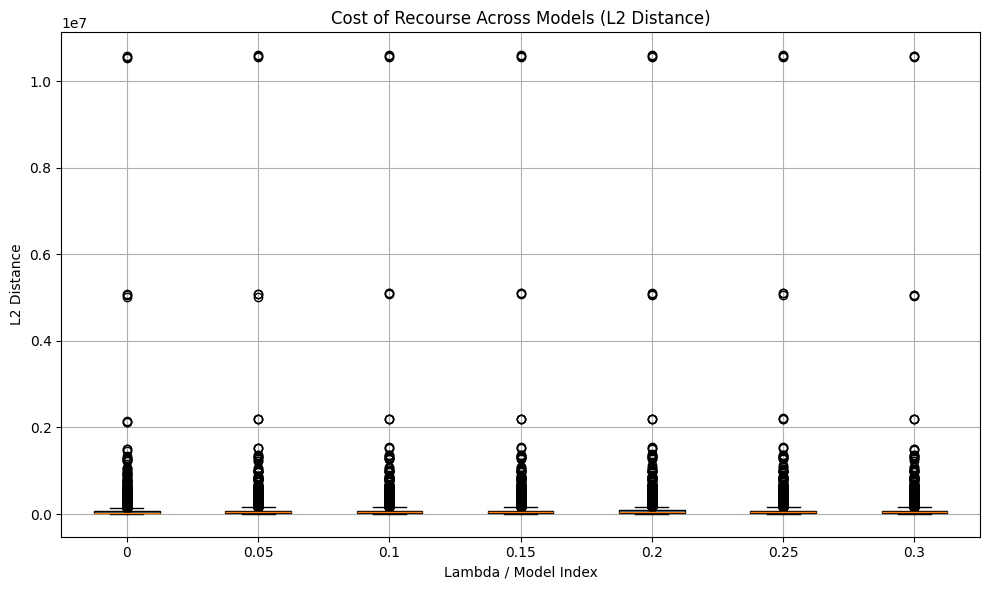

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

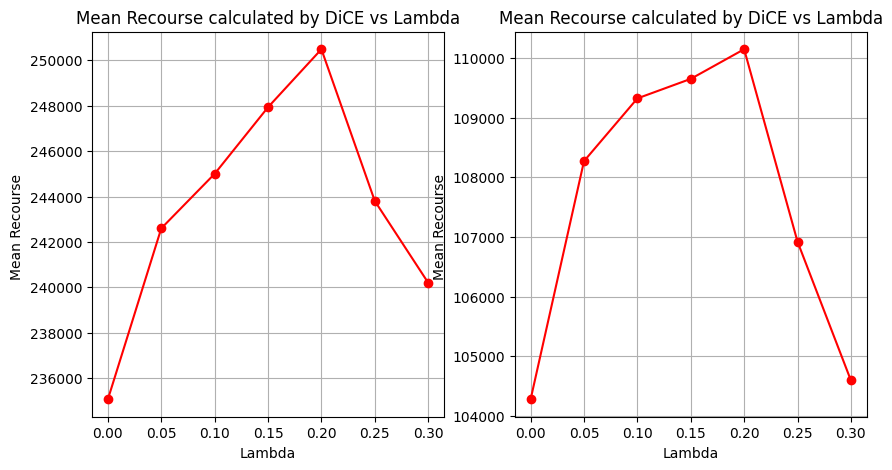

In [7]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]
l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by DiCE vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)